# importing the required libraries for the analysis

pandas is a library in Python programming language for data manipulation and analysis. In particular, it offers data structures and operations for manipulating tables like Microsoft excel.

# Data Description


1. Month, DayofMonth, DayOfWeek
2. DepTime – departure time
3. UniqueCarrier – code of a company-career
4. Origin – flight origin
5. Dest – flight destination
6. Distance, distance between Origin and Dest airports
7. dep_delayed_15min – target

In [228]:
# importing the required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from datetime import datetime
import statsmodels.api as sm
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier

In [229]:
df_train = pd.read_csv('flight_delays_train.csv')

In [230]:
# we will view the first five rows of the dataset to know how the data looks like
df_train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [231]:
df_train.shape   # viewing the dimension of the data

(100000, 9)

## Cleaning the c- month, DayofMonth and DayOfWeek so as to read meaningful insights into the features

In [232]:
def remove_characters(row):
    """
    this function splits a string at the postion of "-" and selects the last item
    """
    result = row.split('-')[-1]
    return int(result)

In [233]:
def preprocess(df):
    """
    This function performs data procession on the data
    """
    df["Flight"] = df["Origin"] + "-" + df["Dest"] # concatenating the origin and destination column together
    df["Hour"] = df["DepTime"] // 100  #converting the Departure time to Hour of departure
    df['Month'] = df['Month'].map(lambda row: remove_characters(row))  # extracting th month string
    df['DayofMonth'] = df['DayofMonth'].map(lambda row: remove_characters(row))  # exteacting the day of month string
    df['DayOfWeek'] = df['DayOfWeek'].map(lambda row: remove_characters(row))  # extracting the day of week string

#     airport_to_state = pd.read_csv("../input/airport-to-statecsv/airport_to_state.csv", usecols=["airport", "state"])
#     df = X.merge(airport_to_state, left_on="Origin", right_on="airport", how="left")
    if "dep_delayed_15min" in df.columns:
        df["dep_delayed_15min"] = df["dep_delayed_15min"].map({"Y": 'Yes', "N":'No'})
    
    return df

In [234]:
df = preprocess(df_train)

In [235]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Month,100000.0,6.53764,3.413447,1.0,4.0,7.0,9.0,12.0
DayofMonth,100000.0,15.70385,8.793931,1.0,8.0,16.0,23.0,31.0
DayOfWeek,100000.0,3.95183,1.991640,1.0,2.0,4.0,6.0,7.0
DepTime,100000.0,1341.52388,476.378445,1.0,931.0,1330.0,1733.0,2534.0
Distance,100000.0,729.39716,574.616860,30.0,317.0,575.0,957.0,4962.0
Hour,100000.0,13.11958,4.771657,0.0,9.0,13.0,17.0,25.0


In [143]:
def assign_flight_number(df):
    """
    This function assigns a unique number to each flights in the dataset
    """
    flights = list(df['Flight'].unique())
    flight_dict = {}
    item = 1
    for flight in flights:
        flight_dict[flight] = item
        item += 1
    df['flight_count'] = df['Flight'].map(lambda row: flight_dict[row])
    return df

df = assign_flight_number(df)

In [144]:
def index_to_value(df, column, index_list, value_list):
    
    """
    This function converts an item index to value and the value to as the idex
    """
    
    result = dict(zip(index_list, value_list))
    df[column] = df[column].map(lambda row: result[row])
    return df

In [145]:
def process_day_month(df):
    """
    using the index_to_value function, this function converts weekday and month index to their respective names
    """
    weekdays = [u"Mon", u"Tue", u"Wed", u"Thu", u"Fr", u"Sat", u"Sun"]
    months = [u"Jan", u"Feb", u"Mar", u"Apr", u"May", u"Jun", u"Jul", u"Aug", u"Sep", u"Oct", u"Nov", u"Dec"]
    
    month_index = sorted(df['Month'].unique())
    day_index = sorted(df['DayOfWeek'].unique())
    
    df = index_to_value(df, 'Month', month_index, months)
    df = index_to_value(df, 'DayOfWeek', day_index, weekdays)
    
    return df

df = process_day_month(df)

In [146]:
def process_period(df):
    """
    This function divides the hour of a day into the morning, afternoon and night
    """
    df.loc[(df['Hour'] >= 0) & (df['Hour'] < 12), 'Period'] = 'Midnight - Morning'
    df.loc[(df['Hour'] >= 12) & (df['Hour'] <= 17), 'Period'] = 'Noon'
    df.loc[df['Hour'] > 17, 'Period'] = 'Evening - Night'
    
    return df

df = process_period(df)

## How is the delay of flights distributed

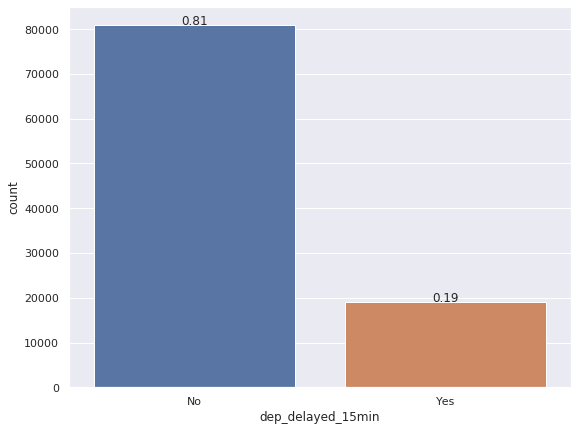

In [239]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(9,7))
ax = sns.countplot(x='dep_delayed_15min', data=df, ax = axes,);

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/float(len(df))),
            ha="center")

## What is the distribution of the distance between origin and destination

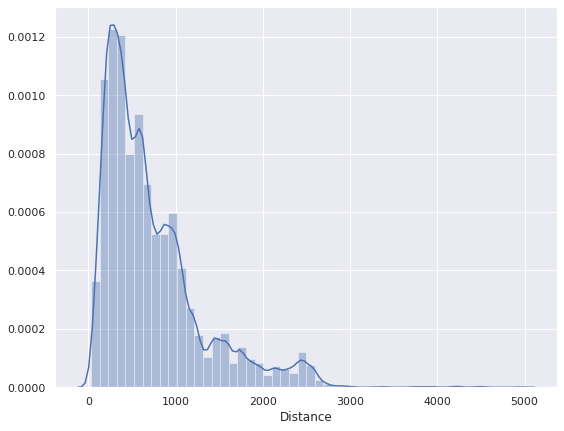

In [107]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,7))
sns.distplot(df['Distance'], ax=ax);

# Understanding the distribution of delayed flights over day, month, hour of flight, distance, and flight carrier

Since our major objective is to understand how flights that are delayed are distributed, we will only focus on the delayed flights over the above features. 

To do this, we will select only the flights that were delayed and examine their distribution accross all the features highlighted above

In [108]:
delayed_df = df[df['dep_delayed_15min'] == 'Yes']  # filtering the data for only when delay equal yes

## How is flight delay distributed among the days of the week

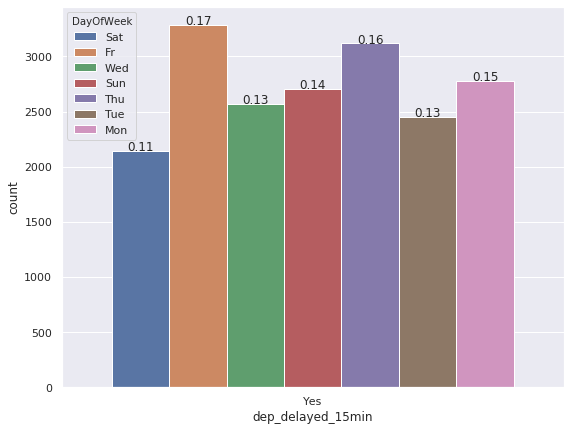

In [242]:
# creating a countplot

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(9,7)) # increasing how large the plot is shown
ax = sns.countplot(x='dep_delayed_15min', hue='DayOfWeek', data=delayed_df, ax=axes);

# getting the proportion of the count to the total delayed flights and showing on each bar
for p in ax.patches:
    height = p.get_height()  
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/float(len(delayed_df))),
            ha="center")

## How is flight delay distributed over period of the day

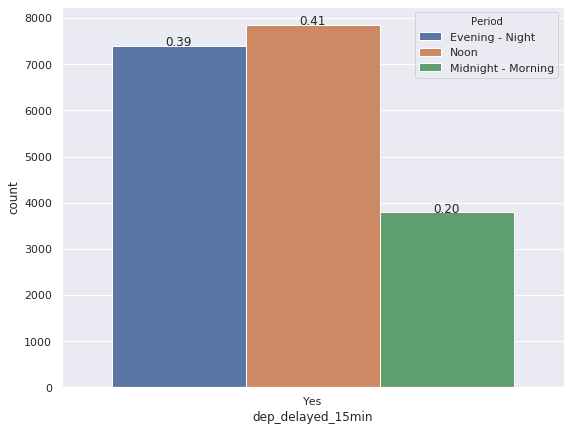

In [243]:
# creating a countplot

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(9,7))
ax = sns.countplot(x='dep_delayed_15min', hue='Period', data=delayed_df, ax=axes);

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/float(len(delayed_df))),
            ha="center")

## How are delayed flights distributed over the months

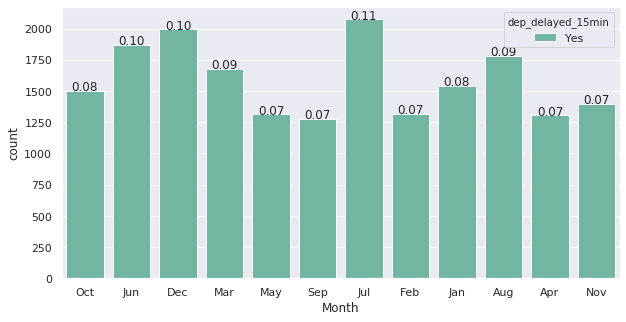

In [244]:
plt.figure(figsize=(10,5))
ax = sns.countplot(x='Month', hue='dep_delayed_15min', data=delayed_df, palette='Set2');

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/float(len(delayed_df))),
            ha="center")

## How are delayed flights distributed over the UniqueCarriers

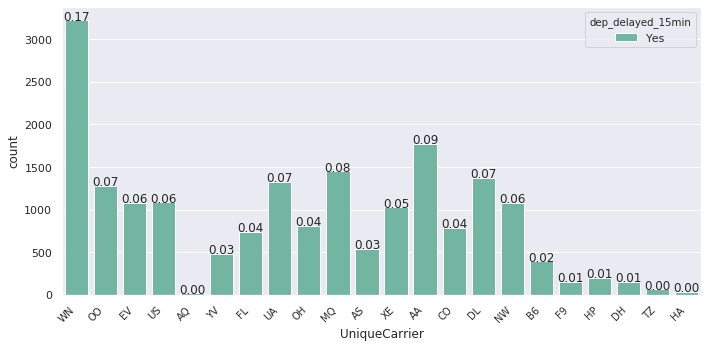

In [246]:
plt.figure(figsize=(10,5))
ax = sns.countplot(x='UniqueCarrier', hue='dep_delayed_15min', data=delayed_df, palette='Set2');
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='small'  
);
plt.tight_layout()

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/float(len(delayed_df))),
            ha="center")

## What is the monthly average hour of the delayed flights

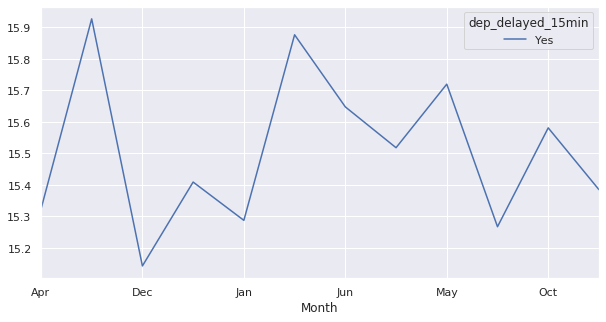

In [249]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
delayed_df.pivot_table(index='Month', columns='dep_delayed_15min', values='Hour', aggfunc='mean').sort_index().plot(ax=ax);

## what is the hourly average distance of destination delayed flights

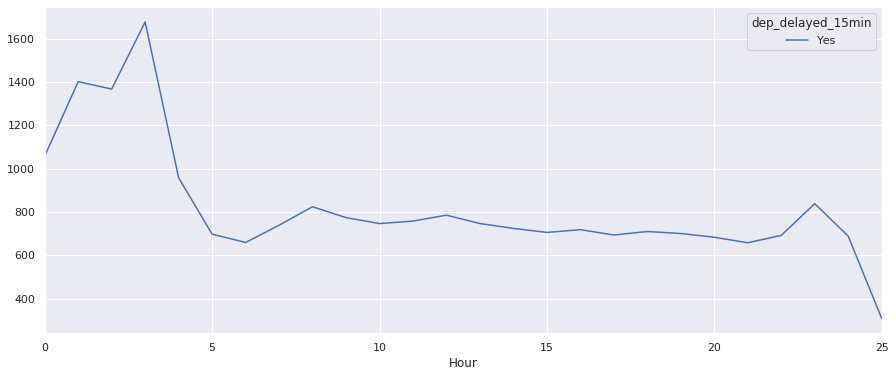

In [114]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,6))
delayed_df.pivot_table(index='Hour', columns='dep_delayed_15min', values='Distance', aggfunc='mean').plot(ax=ax);

## What is the daily average hour of the delayed flights

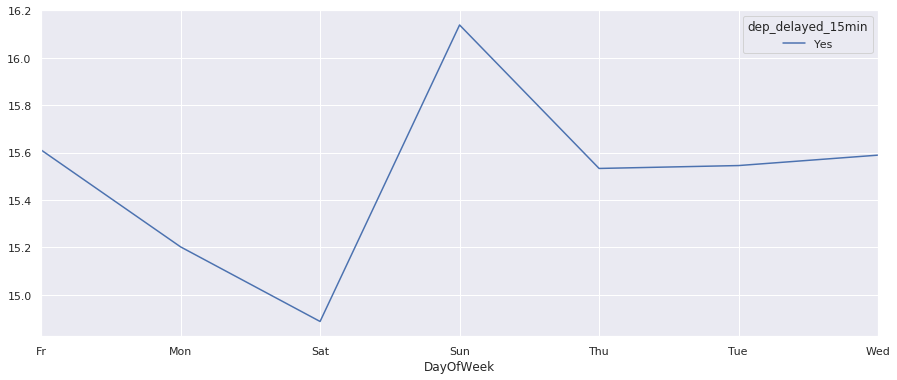

In [250]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,6))
delayed_df.pivot_table(index='DayOfWeek', columns='dep_delayed_15min', values='Hour').sort_index().plot(ax=ax);

# Training the Logistics Regression Model

In [173]:
def prepare_model_data(df):
    """
    This functions selects the features to be used from the whole dataset and prepare the for the model
    """
    cat_vars = df[['Month', 'DayofMonth','DayOfWeek']]
    cat_features = pd.get_dummies(cat_vars, drop_first=True)  # creating dummy variables of the categorical features
    other_features = df[['Hour', 'Distance']]
    X = pd.concat([cat_features, other_features], axis=1)

    return X
X = prepare_model_data(df)

In [427]:
X = pd.concat([cat_features, other_features], axis=1)

In [174]:
X.head()

,DayofMonth,Month_Aug,Month_Dec,Month_Feb,Month_Jan,Month_Jul,Month_Jun,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,DayOfWeek_Mon,DayOfWeek_Sat,DayOfWeek_Sun,DayOfWeek_Thu,DayOfWeek_Tue,DayOfWeek_Wed,Hour,Distance
0,21,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,19,732
1,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,15,834
2,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,14,416
3,25,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,10,872
4,7,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,18,423


In [148]:
y = df.pop('dep_delayed_15min')
y = y.map({'Yes':1, 'No':0})

In [185]:
# splitting into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [210]:
# computing the accuracy of the DecisionTree for difeerent max_depth and comparing the accuracy of each model

ccuracy_train = []
accuracy_test = []

for i in range(1,21):
    model = DecisionTreeClassifier(max_depth=i)  #Intantiating the model to max_dept of i
    model.fit(X_train, y_train)  # training the model
    y_train_pred = model.predict(X_train) # predicting for the training set
    y_pred = model.predict(X_test)  # predicting for the testing set
    
    accuracy_train.append(accuracy_score(y_train,y_train_pred))
    accuracy_test.append(accuracy_score(y_test, y_pred))
    

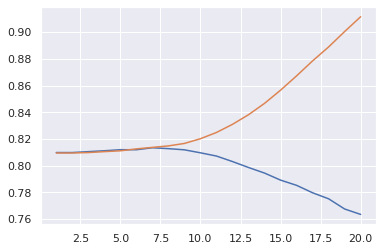

In [217]:
plt.plot(list(range(1,21)),accuracy_test)
plt.plot(list(range(1,21)),accuracy_train);

The plot above shows that the model with the best accuracy for training and testing set is the one with max_depth equal 7

In [213]:
model = DecisionTreeClassifier(max_depth=7)
model.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=7, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [214]:
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)

In [218]:
print(accuracy_score(y_train,y_train_pred))
print(accuracy_score(y_test, y_pred))

0.8136417910447761
0.8133333333333334


In [252]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.82      0.99      0.90     26723
           1       0.60      0.05      0.10      6277

    accuracy                           0.81     33000
   macro avg       0.71      0.52      0.50     33000
weighted avg       0.78      0.81      0.74     33000



In [256]:
print(confusion_matrix(y_test,y_pred))

[[26502   221]
 [ 5939   338]]
